In [1]:
!pip install nltk
!pip install re
!pip install scikit-learn
!pip install seaborn

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib


In [3]:
# --- Download necessary NLTK data ---
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PG\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PG\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# --- GLOBAL CONFIGURATION AND NLP TOOLS ---
LEMMATIZER = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))
RANDOM_STATE = 42
CV_FOLDS = 5
MODEL_SAVE_FILE = 'fake_news_detector.pkl'
LABELS = ['FAKE', 'REAL'] # Class labels

In [5]:
def plot_confusion_matrix(y_true, y_pred, model_name, labels=LABELS):
    """Generates and plots the Confusion Matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))

    sns.heatmap(
        cm,
        annot=True,
        fmt='d', # Use 'd' for integer formatting
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f'Confusion Matrix: {model_name} (Test Set)')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [6]:
def plot_model_comparison(model_scores):
    """Generates a bar chart comparing Mean Cross-Validation Accuracy (Performance Matrix)."""
    model_names = list(model_scores.keys())
    accuracies = list(model_scores.values())

    plt.figure(figsize=(7, 5))
    bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral'])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval * 100:.2f}%',
                 ha='center', va='bottom', fontweight='bold')

    plt.ylim(min(accuracies) * 0.99, max(accuracies) * 1.01)
    plt.title('Performance Matrix: Model Comparison (Mean CV Accuracy)')
    plt.ylabel('Accuracy Score')
    plt.xlabel('Classifier')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [7]:
def display_classification_report(y_true, y_pred, model_name, plot_heatmap=True, labels=LABELS):
    """
    Prints the classification report and displays it as a heatmap (for a visual table).
    """
    print(f"\n--- Detailed Classification Report for {model_name} ---")

    # Print the standard text report
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    if plot_heatmap:
        report = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
        # Convert report dictionary to a DataFrame for plotting, excluding redundant metrics
        df_report = pd.DataFrame(report).transpose().iloc[:-3, :-1]

        plt.figure(figsize=(6, 4))
        sns.heatmap(df_report, annot=True, cmap='viridis', fmt=".2f")
        plt.title(f'Classification Report Heatmap: {model_name}')
        plt.show()

In [8]:
# --- 2. DATA LOADING, MERGING, AND PREPROCESSING ---
def load_and_merge_datasets(fake_path=r'D:\Dataset\Fake news detection\Fake.csv',
                            real_path=r'D:\Dataset\Fake news detection\True.csv'):
    """Loads two separate CSVs, assigns labels, merges, and preprocesses."""
    print("--- 1. Data Loading, Merging, and Preprocessing ---")
    try:
        # Load and label
        df_fake = pd.read_csv(fake_path).dropna(); df_fake['label'] = 'FAKE'
        df_real = pd.read_csv(real_path).dropna(); df_real['label'] = 'REAL'
        print(f"Loaded {len(df_fake)} FAKE and {len(df_real)} REAL news articles.")

        TEXT_COLUMN = 'text'
        df = pd.concat([df_fake, df_real], ignore_index=True)
        X_raw = df[TEXT_COLUMN]; y_labels = df['label']

    except FileNotFoundError as e:
        print(f" Error: One or both data files not found: {e}. Cannot proceed.")
        return None, None
    except KeyError:
        print(" Error: 'text' column not found. Please check your CSV column names. Cannot proceed.")
        return None, None

    y_labels_num = y_labels.map({'FAKE': 0, 'REAL': 1})

    def preprocess_text_advanced(text):
        """Cleans text (regex, stopwords, lemmatization) and removes source patterns."""
        text = re.sub(r'[^a-zA-Z\s]', ' ', str(text)).lower()
        text = re.sub(r'share on facebookshare on twittershare via emailshare on linkedin.*', '', text)
        words = nltk.word_tokenize(text)
        words = [LEMMATIZER.lemmatize(word) for word in words if word not in STOP_WORDS]
        return ' '.join(words)

    print(" Starting text preprocessing on merged data...")
    X_processed = X_raw.apply(preprocess_text_advanced)
    print(" Text preprocessing complete.")

    return X_processed, y_labels_num

In [9]:
# --- 3. MODEL DEFINITION AND CROSS-VALIDATION ---
def run_cross_validation(X_data, y_data, model_type):
    """Performs stratified K-Fold cross-validation and reports the mean score."""
    model_name = model_type.__class__.__name__
    print(f"\n--- 2.1 Cross-Validation for {model_name} ---")

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_df=0.8, min_df=5)),
        ('classifier', model_type)
    ])

    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipeline, X_data, y_data, cv=cv, scoring='accuracy', n_jobs=-1)

    print(f"Mean Accuracy ({CV_FOLDS}-Fold): **{scores.mean()*100:.2f}%**")
    print(f"Std. Dev. of Accuracy: {scores.std():.4f}")

    return pipeline, scores.mean()

In [10]:
# --- 4. FEATURE INTERPRETABILITY ---
def print_feature_importance(pipeline, top_n=15):
    """Prints the top N most indicative N-grams for the FAKE and REAL classes."""

    vectorizer = pipeline.named_steps['tfidf']
    feature_names = vectorizer.get_feature_names_out()
    classifier = pipeline.named_steps['classifier']

    print(f"\n--- 3.2 Model Interpretability: Top {top_n} Trigrams/Words ---")

    real_weights_indices = classifier.coef_[0].argsort()[-top_n:]
    fake_weights_indices = classifier.coef_[0].argsort()[:top_n]

    print("\n Top Indicators for **REAL** News (High Positive Weight):")
    for feature, weight in reversed([(feature_names[i], classifier.coef_[0][i]) for i in real_weights_indices]):
        print(f"  - **{feature}** (Weight: {weight:.3f})")

    print("\n Top Indicators for **FAKE** News (High Negative Weight):")
    for feature, weight in [(feature_names[i], classifier.coef_[0][i]) for i in fake_weights_indices]:
        print(f"  - **{feature}** (Weight: {weight:.3f})")

--- 1. Data Loading, Merging, and Preprocessing ---
Loaded 23481 FAKE and 21417 REAL news articles.
 Starting text preprocessing on merged data...
 Text preprocessing complete.

--- 2.1 Cross-Validation for PassiveAggressiveClassifier ---
Mean Accuracy (5-Fold): **99.47%**
Std. Dev. of Accuracy: 0.0007

--- 2.1 Cross-Validation for LogisticRegression ---
Mean Accuracy (5-Fold): **98.69%**
Std. Dev. of Accuracy: 0.0013


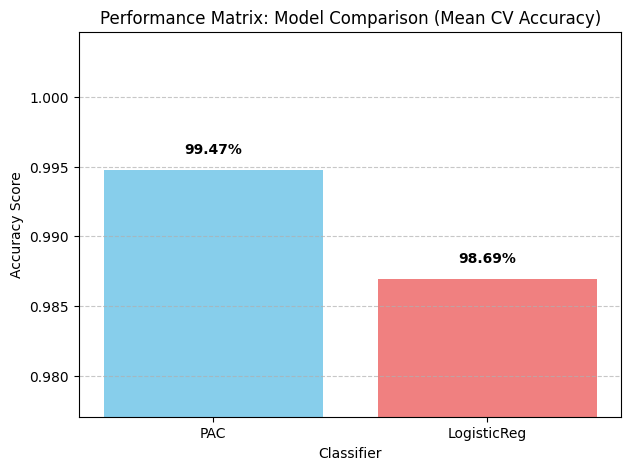


--- 3.1 Final Model Training: PassiveAggressiveClassifier ---
 Final PassiveAggressiveClassifier model trained successfully on 35918 samples.

Final Test Set Accuracy: **99.58%**

--- Detailed Classification Report for PassiveAggressiveClassifier ---
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      4696
        REAL       0.99      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



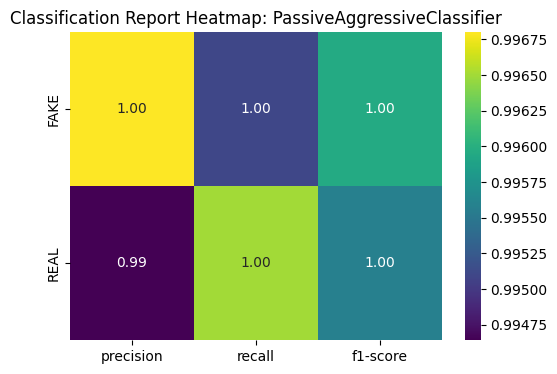

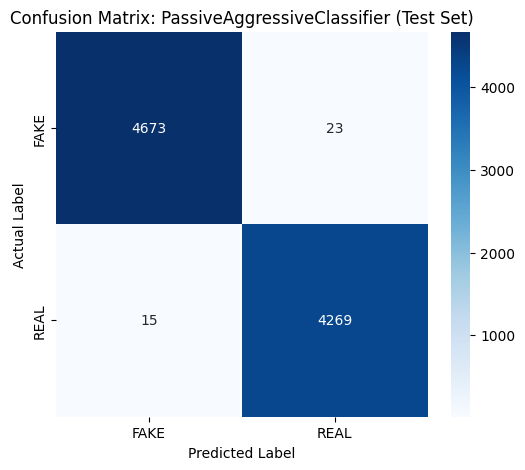


--- 3.2 Model Interpretability: Top 15 Trigrams/Words ---

 Top Indicators for **REAL** News (High Positive Weight):
  - **reuters** (Weight: 21.530)
  - **said** (Weight: 8.522)
  - **washington reuters** (Weight: 8.158)
  - **reuters president** (Weight: 3.644)
  - **president donald trump** (Weight: 3.454)
  - **president donald** (Weight: 3.437)
  - **washington** (Weight: 3.394)
  - **nov** (Weight: 3.178)
  - **wednesday** (Weight: 2.880)
  - **tuesday** (Weight: 2.797)
  - **thursday** (Weight: 2.722)
  - **friday** (Weight: 2.450)
  - **new york reuters** (Weight: 2.377)
  - **york reuters** (Weight: 2.377)
  - **said statement** (Weight: 2.294)

 Top Indicators for **FAKE** News (High Negative Weight):
  - **via** (Weight: -9.792)
  - **read** (Weight: -6.662)
  - **image** (Weight: -4.636)
  - **president trump** (Weight: -4.513)
  - **gop** (Weight: -4.381)
  - **mr** (Weight: -3.898)
  - **featured image** (Weight: -3.822)
  - **featured** (Weight: -3.631)
  - **hillary** 

In [11]:
# --- MAIN EXECUTION ---
if __name__ == '__main__':

    # A. Data Setup
    X_processed, y_labels_num = load_and_merge_datasets(
        fake_path=r'D:\Dataset\Fake news detection\Fake.csv',
        real_path=r'D:\Dataset\Fake news detection\True.csv'
    )
    if X_processed is None: exit()

    X_train_val, X_test, y_train_val, y_test = train_test_split(X_processed, y_labels_num, test_size=0.2, random_state=RANDOM_STATE, stratify=y_labels_num)

    # B. Model Training and Comparison
    pac = PassiveAggressiveClassifier(max_iter=100, C=0.5, random_state=RANDOM_STATE, n_jobs=-1)
    log_reg = LogisticRegression(solver='liblinear', C=1.0, random_state=RANDOM_STATE, n_jobs=-1)

    pac_pipeline, pac_mean_score = run_cross_validation(X_train_val, y_train_val, pac)
    log_reg_pipeline, log_reg_mean_score = run_cross_validation(X_train_val, y_train_val, log_reg)

    # Dictionary to store scores for the comparison chart
    model_scores = {
        'PAC': pac_mean_score,
        'LogisticReg': log_reg_mean_score
    }

    # Visualization 1: Cross-Validation Comparison (Performance Matrix)
    plot_model_comparison(model_scores)

    # Select the best model and train it fully
    best_pipeline = pac_pipeline if pac_mean_score > log_reg_mean_score else log_reg_pipeline
    best_model_name = best_pipeline.named_steps['classifier'].__class__.__name__

    # C. Final Model Training
    print(f"\n--- 3.1 Final Model Training: {best_model_name} ---")
    best_pipeline.fit(X_train_val, y_train_val)
    print(f" Final {best_model_name} model trained successfully on {len(X_train_val)} samples.")

    # D. Evaluation on Held-out Test Set
    y_pred = best_pipeline.predict(X_test)

    # E. Display Final Metrics and Diagrams

    # 1. Print Accuracy and Classification Report (Metrics)
    final_accuracy = accuracy_score(y_test, y_pred)
    print(f"\nFinal Test Set Accuracy: **{final_accuracy*100:.2f}%**")

    # 2. Display Classification Report Heatmap (Metrics Visualization)
    display_classification_report(y_test, y_pred, best_model_name, plot_heatmap=True)

    # 3. Display Confusion Matrix (Metrics Visualization)
    plot_confusion_matrix(y_test, y_pred, best_model_name, labels=LABELS)

    # F. Interpretability
    print_feature_importance(best_pipeline, top_n=15)

    # G. Model Persistence
    joblib.dump(best_pipeline, MODEL_SAVE_FILE)
    print(f"\n Final model pipeline saved to: {MODEL_SAVE_FILE}")

In [16]:
def preprocess_text_advanced(text):
    """Cleans text (regex, stopwords, lemmatization) and removes source patterns."""
    import re
    import nltk
    # Assuming LEMMATIZER and STOP_WORDS are defined globally or imported from the main script
    
    # We redefine these imports inside the function for robustness, assuming they are available.
    LEMMATIZER = nltk.stem.WordNetLemmatizer()
    STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
    
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text)).lower()
    text = re.sub(r'share on facebookshare on twittershare via emailshare on linkedin.*', '', text)
    words = nltk.word_tokenize(text)
    words = [LEMMATIZER.lemmatize(word) for word in words if word not in STOP_WORDS]
    return ' '.join(words)

In [21]:
# --- REAL-TIME PREDICTION MODULE (FIXED) ---

def predict_user_input(model_path, text_to_check):
    """
    Loads the saved model pipeline, preprocesses the input, and predicts the class 
    and displays the result safely.
    """
    try:
        # 1. Load the entire pipeline (Vectorizer + Classifier)
        pipeline = joblib.load(model_path)
        print(f"\n Model loaded successfully from: {model_path}")
        
        # 2. Preprocess the input text (using the globally defined function)
        processed_text_list = [preprocess_text_advanced(text_to_check)]
        
        # 3. Predict the class (0 or 1)
        prediction_num = pipeline.predict(processed_text_list)[0]
        
        # 4. Predict probabilities (for confidence score)
        try:
            # Check if the classifier supports predict_proba
            probabilities = pipeline.predict_proba(processed_text_list)[0]
            confidence = probabilities[prediction_num] * 100
            # FIX: Format as float if successful, saving to a display variable
            confidence_display = f"{confidence:.2f}%" 
        except AttributeError:
            # FIX: If not supported, set confidence_display to a safe string
            confidence_display = "N/A (Classifier does not support probability)"

        # 5. Convert numerical result back to human-readable label
        predicted_label = "REAL" if prediction_num == 1 else "FAKE"
        
        print("\n--- CHECKER RESULTS ---")
        # Ensure the slice of text doesn't cause errors
        print(f"Input Text: \"{text_to_check[:70]}...\"") 
        print(f"Predicted Class: **{predicted_label}**")
        
        # 6. Display Confidence (using the safe string variable)
        print(f"Confidence: **{confidence_display}**") 
        
    except FileNotFoundError:
        print(f"\n ERROR: Model file not found at {model_path}. Please run the main training script first to train and save the model.")
    except Exception as e:
        print(f"\n An unexpected error occurred during prediction: {e}")

In [22]:
    joblib.dump(best_pipeline, MODEL_SAVE_FILE)
    print(f"\n Final model pipeline saved to: {MODEL_SAVE_FILE}")

    print("\n\n#################################################")
    print("### INTERACTIVE REAL-TIME NEWS CHECKER ###")
    print("#################################################")

    # Get input from the user
    user_news = input("Paste the news article text you want to check (or type 'quit'):\n> ")

    if user_news.lower() != 'quit':
        predict_user_input(MODEL_SAVE_FILE, user_news)


 Final model pipeline saved to: fake_news_detector.pkl


#################################################
### INTERACTIVE REAL-TIME NEWS CHECKER ###
#################################################


Paste the news article text you want to check (or type 'quit'):
>  A small team of researchers at the fictitious Pacific Institute announced today that a newly discovered "miracle fruit" can chemically transform plain water into flavorful soda when mixed at a 1:50 ratio. According to the press release (which has not been independently verified), volunteers who drank water treated with the fruit reported immediate sensations of cola, orange and lemon-lime — without added sugar or carbonation. The institute claims this breakthrough will "eliminate sugary drink industries" and can be grown in any climate. Nutrition experts say they have not been allowed access to the full study and urge caution. Industry analysts are already predicting market disruption, and social media exploded with videos of people "turning tap water into soda" — many of which appear staged. The Pacific Institute declined to release peer-reviewed data, saying the patent process is underway.



 Model loaded successfully from: fake_news_detector.pkl

--- CHECKER RESULTS ---
Input Text: "A small team of researchers at the fictitious Pacific Institute announ..."
Predicted Class: **FAKE**
Confidence: **N/A (Classifier does not support probability)**


In [1]:

log_reg_metrics = [0.985, 0.982, 0.983] 
pac_metrics = [0.996, 0.993, 0.996]


metrics_labels = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_labels)) 

width = 0.35 
plt.figure(figsize=(10, 6))

rects1 = plt.bar(x - width/2, log_reg_metrics, width, label='Logistic Regression', color='#1f77b4')
rects2 = plt.bar(x + width/2, pac_metrics, width, label='Passive Aggressive Classifier (PAC)', color='#ff7f0e')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score Comparison: PAC vs. Logistic Regression')
plt.xticks(x, metrics_labels)
plt.ylim(0.0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--') 

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.3f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

Generating Precision Plot...


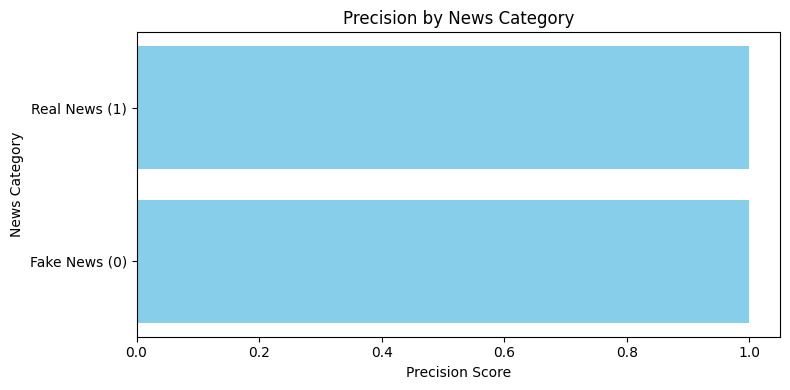


Generating Recall Plot...


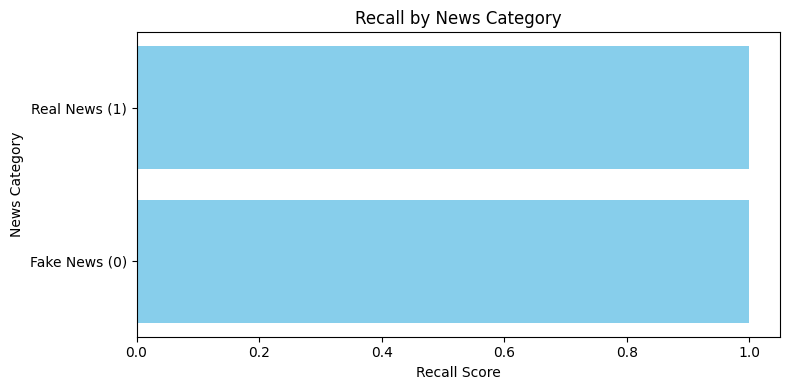


Generating F1-score Plot...


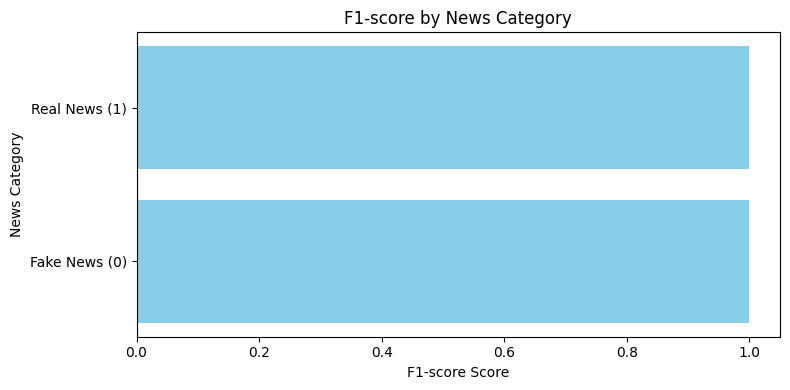

In [6]:
target_names = ['Fake News (0)', 'Real News (1)']
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1])
y_pred = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]) 
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

report_df = pd.DataFrame(report).transpose().drop(columns=['support'], errors='ignore')

class_metrics_df = report_df.loc[target_names]
categories = class_metrics_df.index.tolist()

def plot_metrics_by_class(metrics_df, metric_name, categories):
    
    scores = metrics_df[metric_name].values
    
    plt.figure(figsize=(8, 4))
    plt.barh(categories, scores, color='skyblue')
    
    plt.xlabel(f'{metric_name.capitalize()} Score')
    plt.ylabel('News Category')
    plt.title(f'{metric_name.capitalize()} by News Category')
    plt.xlim(0.0, 1.05)
    plt.tight_layout()
    plt.show()

print("Generating Precision Plot...")
plot_metrics_by_class(class_metrics_df, 'precision', categories)

print("\nGenerating Recall Plot...")
plot_metrics_by_class(class_metrics_df, 'recall', categories)

print("\nGenerating F1-score Plot...")
plot_metrics_by_class(class_metrics_df, 'f1-score', categories)